In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

/home/kogora/AdiskD/PROG_SPBGU_HW/PROG_SPBU_3/ml-course/task-impls/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Для работы будет использован датасет [mnist](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv). Он включает 60_000 черно-белых изображений размером 28x28 пикселей, на которых представлены цифры от 0 до 9. Таким образом, датасет содержит 10 различных классов.

In [5]:
path = Path(kagglehub.dataset_download("oddrationale/mnist-in-csv"))

In [6]:
df = pd.read_csv(path / "mnist_train.csv")
labels = df["label"]
labels.value_counts(sort=True)

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

Подготовим датасет (уберем лейблы).

In [7]:
df.drop(columns=['label'], inplace=True)

## EDA

Попробуем визуализировать данные, используя методы снижения размерности. После этого определим, до какого уровня можно уменьшить размерность, сохранив при этом основную часть информации без значительных потерь.

### Визуализация (PCA и t-SNE)

Уменьшим размерность данных до двух и визуализируем полученный результат: 

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

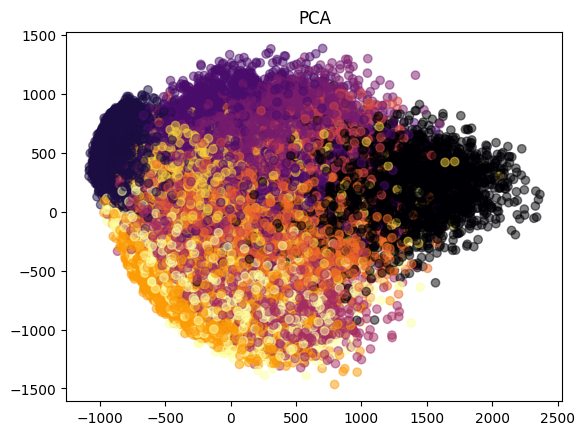

In [33]:
pca = PCA()
pca_res = pca.fit_transform(df)
plt.scatter(pca_res[:,0], pca_res[:,1], cmap='inferno', c=labels, alpha=0.5)
plt.title('PCA');

*ВЫВОД*: Легко заметить, что четко выделяются 4 класса, однако в середине графика все перемешано, что затруднеет определение большего числа классов.

В попытке получить более четкий результат попробуем алгоритм t-SNE:

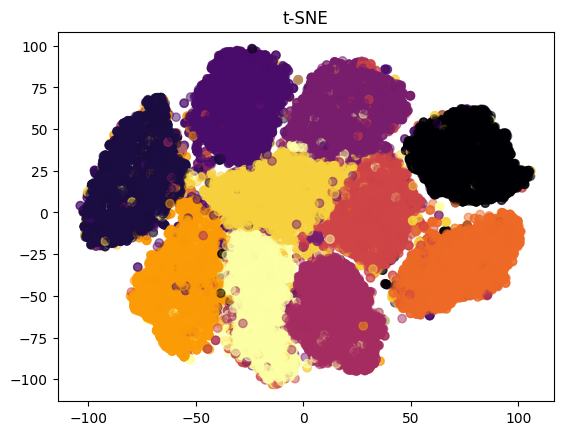

In [35]:
tsne_res = TSNE().fit_transform(df)
plt.scatter(tsne_res[:,0], tsne_res[:,1], cmap='inferno', c=labels, alpha=0.5)
plt.title('t-SNE');

*ВЫВОД*: Теперь явно видно 10 классов, что соответствует реальности.

## Понижение размерности

Попробуем снизить размерность воспользовавшись тем фактом, что скорее всего не все пиксели важны:

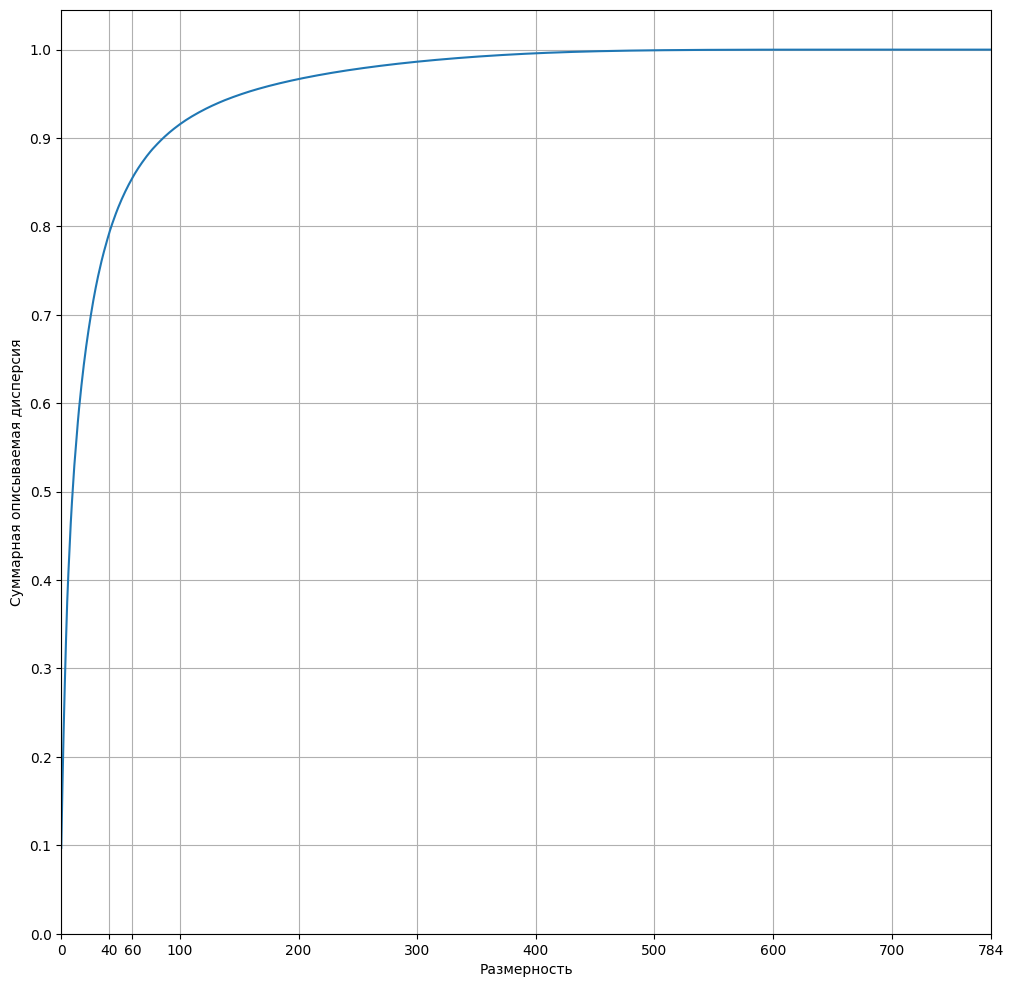

In [37]:
plt.figure(figsize=(12, 12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Суммарная описываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks([*plt.xticks()[0], 40, 60, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

Можно сделать вывод, что размерность 40 охватывает около 80% дисперсии, размерность 60 — более 85%, а размерность 100 — свыше 90%. Начиная с размерности 400, добавление новых измерений практически не увеличивает количество полезной информации.

## Impl

Собственная простая реализация KMeans:

In [8]:
from typing import Optional
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted, validate_data
from sklearn.utils.estimator_checks import check_estimator
import numpy as np


class CustomKMeans(ClusterMixin, BaseEstimator):
    def __init__(self, n_clusters: int = 10, *, tol: float = 1e-4, random_state: Optional[int] = None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> "CustomKMeans":
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)

        X = validate_data(self, X, y=None, reset=True)
        self.n_features_in_ = X.shape[1]
        self.cluster_centers_ = self._initialize_centers(X)
        self._perform_clustering(X)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        check_is_fitted(self)
        X = validate_data(self, X, y=None, reset=False)
        return self._assign_labels(X)

    def _initialize_centers(self, X: np.ndarray) -> np.ndarray:
        indices = self.random_state_.choice(len(X), size=self.n_clusters, replace=False)
        return X[indices]

    def _perform_clustering(self, X: np.ndarray) -> None:
        max_center_shift = np.inf
        while max_center_shift > self.tol:
            self.labels_ = self._assign_labels(X)
            new_centers = self._compute_new_centers(X, self.labels_)
            max_center_shift = self._compute_max_center_shift(new_centers)
            self.cluster_centers_ = new_centers

    def _assign_labels(self, X: np.ndarray) -> np.ndarray:
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        return np.argmin(distances, axis=1)

    def _compute_new_centers(self, X: np.ndarray, labels: np.ndarray) -> np.ndarray:
        new_centers = np.empty((self.n_clusters, self.n_features_in_))
        for label in np.unique(labels):
            new_centers[label] = np.mean(X[labels == label], axis=0)
        return new_centers

    def _compute_max_center_shift(self, new_centers: np.ndarray) -> float:
        return np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))


check_estimator(CustomKMeans())

[{'estimator': CustomKMeans(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': CustomKMeans(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': CustomKMeans(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': CustomKMeans(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': CustomKMeans(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to

## Выбор метрик

- Fowlkes-Mallows Index (FMI)
- Adjusted Mutual Information (AMI)
- Adjusted Rand Index (ARI)

In [9]:
RES_PATH = Path("results.csv")
CLUSTERS_NUM = 10

In [12]:
import itertools
import time
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

def generate_parameter_combinations(param_grid):
    return [
        dict(params)
        for params in itertools.product(
            *([(key, value) for value in values] for key, values in param_grid.items())
        )
    ]

def evaluate_clustering(estimator, param_grid, datasets):
    parameter_combinations = generate_parameter_combinations(param_grid)
    results = []

    for dataset in datasets:
        best_ari = (None, None, None)
        best_ami = (None, None, None)
        best_fmi = (None, None, None)

        for params in parameter_combinations:
            model = clone(estimator).set_params(**params)
            start_time = time.perf_counter()
            predictions = model.fit_predict(dataset)
            elapsed_time = time.perf_counter() - start_time

            ari = adjusted_rand_score(labels, predictions)
            if best_ari[0] is None or ari > best_ari[0]:
                best_ari = (ari, elapsed_time, params)

            ami = adjusted_mutual_info_score(labels, predictions)
            if best_ami[0] is None or ami > best_ami[0]:
                best_ami = (ami, elapsed_time, params)

            fmi = fowlkes_mallows_score(labels, predictions)
            if best_fmi[0] is None or fmi > best_fmi[0]:
                best_fmi = (fmi, elapsed_time, params)

        result = {
            "Clusterer": estimator.__class__.__name__,
            "Dimension": dataset.shape[1],
            "Mean F/P Time (s)": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
            "ARI": best_ari[0],
            "AMI": best_ami[0],
            "FMI": best_fmi[0],
        }
        print(result)
        results.append(result)

    pd.DataFrame(results).to_csv(RES_PATH, mode="a", header=not RES_PATH.exists())

datasets = [df, *(PCA(n_components=d).fit_transform(df) for d in [40, 60, 100, 400])]
evaluate_clustering(
    estimator=CustomKMeans(n_clusters=CLUSTERS_NUM, random_state=0),
    param_grid={},
    datasets=datasets,
)

{'Clusterer': 'CustomKMeans', 'Dimension': 784, 'Mean F/P Time (s)': np.float64(209.80421528600004), 'ARI': 0.3925056400687111, 'AMI': np.float64(0.5039975134498511), 'FMI': np.float64(0.4555969422809995)}
{'Clusterer': 'CustomKMeans', 'Dimension': 40, 'Mean F/P Time (s)': np.float64(7.158126857999946), 'ARI': 0.40406791242212603, 'AMI': np.float64(0.517280770378041), 'FMI': np.float64(0.4647128245669634)}
{'Clusterer': 'CustomKMeans', 'Dimension': 60, 'Mean F/P Time (s)': np.float64(12.496936091999942), 'ARI': 0.4058135454163437, 'AMI': np.float64(0.5188575448043096), 'FMI': np.float64(0.4662660382162257)}
{'Clusterer': 'CustomKMeans', 'Dimension': 100, 'Mean F/P Time (s)': np.float64(21.226731048000033), 'ARI': 0.4047962623478206, 'AMI': np.float64(0.5185784746967516), 'FMI': np.float64(0.4653768747792997)}
{'Clusterer': 'CustomKMeans', 'Dimension': 400, 'Mean F/P Time (s)': np.float64(90.73770777199991), 'ARI': 0.3924804162575355, 'AMI': np.float64(0.5039261862733511), 'FMI': np.flo

In [14]:
from sklearn.cluster import KMeans

evaluate_clustering(KMeans(n_clusters=CLUSTERS_NUM, n_init='auto', random_state=0),
               param_grid={"algorithm": ["lloyd", "elkan"]}, datasets=datasets)

{'Clusterer': 'KMeans', 'Dimension': 784, 'Mean F/P Time (s)': np.float64(3.1066843629999994), 'ARI': 0.4268452123608504, 'AMI': np.float64(0.534772166270226), 'FMI': np.float64(0.48849108185167395)}
{'Clusterer': 'KMeans', 'Dimension': 40, 'Mean F/P Time (s)': np.float64(0.40955085600000984), 'ARI': 0.3598143337158181, 'AMI': np.float64(0.48920731242197324), 'FMI': np.float64(0.42756235426931855)}
{'Clusterer': 'KMeans', 'Dimension': 60, 'Mean F/P Time (s)': np.float64(0.43902523799999926), 'ARI': 0.36127505421770506, 'AMI': np.float64(0.48156276654451874), 'FMI': np.float64(0.4261593675738737)}
{'Clusterer': 'KMeans', 'Dimension': 100, 'Mean F/P Time (s)': np.float64(0.4920411990000275), 'ARI': 0.35984375573659405, 'AMI': np.float64(0.48126057865036953), 'FMI': np.float64(0.4249186991207307)}
{'Clusterer': 'KMeans', 'Dimension': 400, 'Mean F/P Time (s)': np.float64(1.8487423710000712), 'ARI': 0.3598433376056855, 'AMI': np.float64(0.48163456092026546), 'FMI': np.float64(0.424920907627

In [ ]:
from sklearn.cluster import DBSCAN

evaluate_clustering(DBSCAN(n_jobs=-1),
               param_grid={"eps": [400, 800, 1200],
                            "min_samples": [20, 40, 80]}, datasets=datasets)

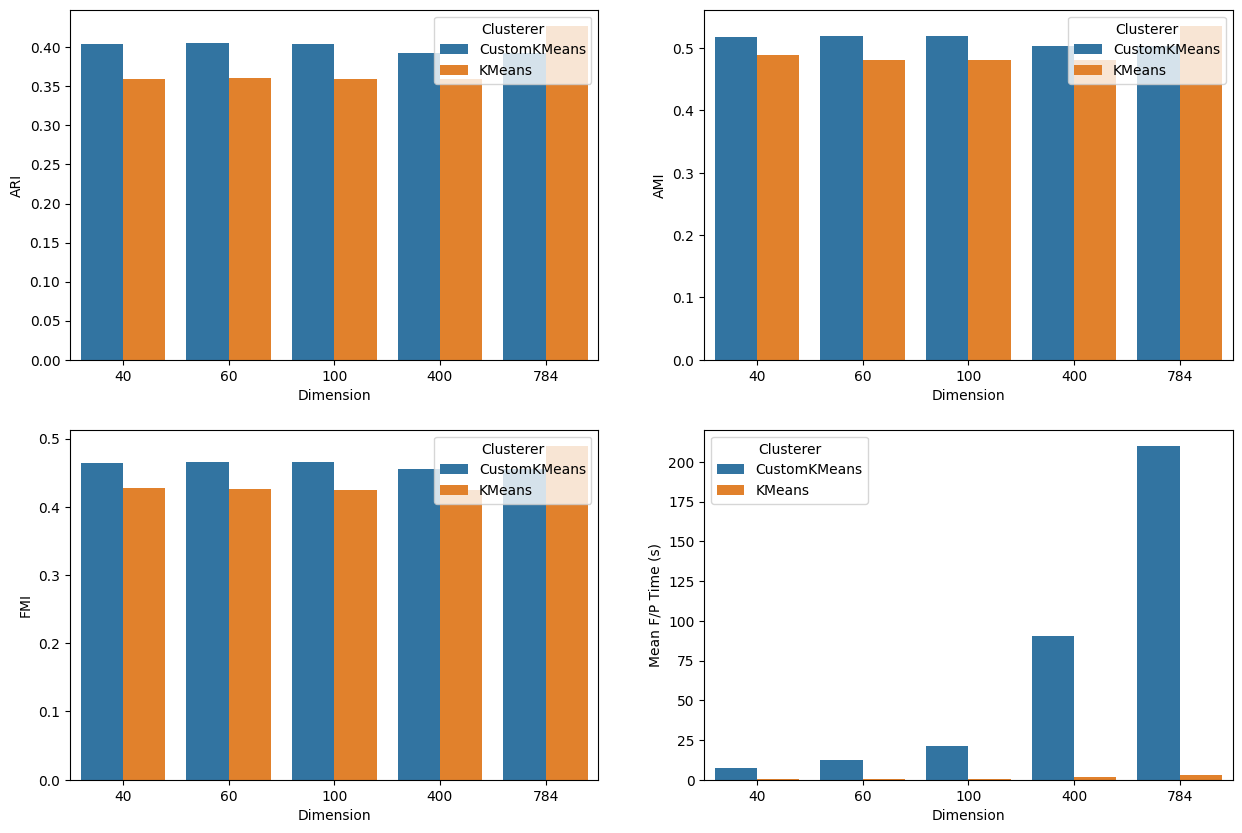

In [17]:
import seaborn as sns

R = pd.read_csv(RES_PATH)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for m_name, ax in zip(
    ["ARI", "AMI", "FMI", "Mean F/P Time (s)"],
    axs.flatten(),
):
    sns.barplot(R, x="Dimension", y=m_name, hue="Clusterer", ax=ax)